In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
from clip_retrieval.clip_back import load_clip_indices, KnnService, ClipOptions, MetadataService,ParquetMetadataProvider

In [11]:
indice_folder = "./improved_aesthetics_6.5plus_clip_retrieval"
clip_options = ClipOptions(
    indice_folder=indice_folder,
    clip_model="open_clip:ViT-B-32/laion2b_s34b_b79k",
    enable_hdf5=False,
    enable_faiss_memory_mapping=False,
    columns_to_return=["url", "caption"],
    reorder_metadata_by_ivf_index=False,
    enable_mclip_option=False,
    use_jit=False,
    use_arrow=False,
    provide_safety_model=False,
    provide_violence_detector=False,
    provide_aesthetic_embeddings=False,
)
columns = ["url", "caption"]
resources = load_clip_indices("./indices_paths.json", clip_options)
knn_service = KnnService(clip_resources=resources)

In [12]:
import base64
from PIL import Image
import json
from datetime import datetime

output_dir = "./result"
input_image = "example/cat.jpg"
import os

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(input_image, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

img_results = []

img_results = knn_service.query(
    image_input=encoded_string,  # img2img
    # text_input="cat",  #txt2img
    modality="image",
    deduplicate=True,
    # image_url_input="https://s3.bmp.ovh/imgs/2024/10/10/9889c696e71bcbbf.jpeg", #imgurl2img
    num_result_ids=10,
)
# print(img_results)
file_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"retrieval_results_{file_timestamp}.json"
with open(os.path.join(output_dir, filename), "w", encoding="utf-8") as f:
    json.dump(img_results, f, ensure_ascii=False, indent=4)
for js in img_results:
    print(js)

{'caption': 'Photograph Cat&girl by Imantas Boiko on 500px', 'id': 35124, 'similarity': 0.74631267786026}
{'caption': 'Wildlife artist-Chat de Garde', 'id': 343184, 'similarity': 0.6789472103118896}
{'caption': 'Street cat by Nikolishin - Only Pets Photo Contest', 'id': 142119, 'similarity': 0.6739814877510071}
{'caption': '1 hyper realistic watercolor painting cat by elena van gelder', 'id': 409118, 'similarity': 0.6593254804611206}
{'caption': 'Portraits of girls with cats, like from the Renaissance 22', 'id': 128939, 'similarity': 0.6537434458732605}


In [13]:
id_values = [item["id"] for item in img_results]
metadata = ParquetMetadataProvider(os.path.join(indice_folder,"metadata"))
image_meta_data = metadata.get(id_values)
for item in image_meta_data:
    print(item)

{'image_path': '000051066', 'caption': 'Photograph Cat&girl by Imantas Boiko on 500px'}
{'image_path': '000408289', 'caption': 'Wildlife artist-Chat de Garde'}
{'image_path': '000194689', 'caption': 'Street cat by Nikolishin - Only Pets Photo Contest'}
{'image_path': '000508902', 'caption': '1 hyper realistic watercolor painting cat by elena van gelder'}
{'image_path': '000190583', 'caption': 'Portraits of girls with cats, like from the Renaissance 22'}


{'WIDTH': 640.0, 'HEIGHT': 960.0, 'punsafe': 0.000640183687210083, 'similarity': 0.3290449380874634, 'caption': 'Photograph Cat&girl by Imantas Boiko on 500px', 'url': 'https://drscdn.500px.org/photo/39151316/m%3D1170_k%3D1_a%3D1/v2?sig=29db100699f6a37ff424a998a14067b026e56941c8caa6c75e55f7fda301112b', 'key': '000051066', 'status': 'success', 'error_message': None, 'width': 640, 'height': 960, 'original_width': 640, 'original_height': 960, 'exif': '{"Image Make": "Canon", "Image Model": "Canon EOS 5D Mark III", "Image Orientation": "Horizontal (normal)", "Image XResolution": "127/5", "Image YResolution": "127/5", "Image ResolutionUnit": "Pixels/Inch", "Image Software": "Adobe Photoshop Lightroom 4.2 (Windows)", "Image DateTime": "2013:06:30 19:48:19", "Image Artist": "Imantas Boiko", "Image ExifOffset": "252", "Thumbnail Compression": "JPEG (old-style)", "Thumbnail XResolution": "72", "Thumbnail YResolution": "72", "Thumbnail ResolutionUnit": "Pixels/Inch", "Thumbnail JPEGInterchangeFo

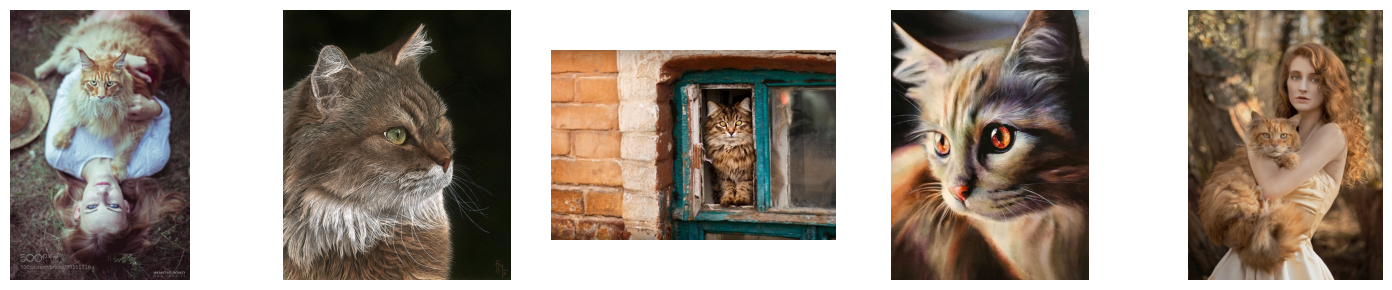

In [21]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt

source_root = "akameswa/improved_aesthetics_6.5plus_webdataset_unzip"

merged_source_json = []
for item in image_meta_data:
    json_path = os.path.join(source_root, item["image_path"] + ".json")
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        print(data)
        merged_source_json.extend(data if isinstance(data, list) else [data])

filename_source = f"source_results_{file_timestamp}.json"
with open(os.path.join(output_dir, filename_source), "w", encoding="utf-8") as f:
    json.dump(merged_source_json, f, ensure_ascii=False, indent=4)

images = [
    Image.open(os.path.join(source_root, item["image_path"] + ".jpg"))
    for item in image_meta_data
]

plt.figure(figsize=(len(images) * 3, 3))

for i, img in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()